# KAN vs MLP for Time Series Forecasting

## 1. Import Packages

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from synthetic import simulate_var
from torch.utils.data import DataLoader, TensorDataset
from models.kan import KAN
from models.model_helper import activation_helper
from tqdm import tqdm

# torch.set_default_dtype(torch.float64)

## 2. Hyperparameters

In [2]:
lag = 3  # number of lags
T = 1000  # number of time points
num_series = 5  # number of time series

batch_size = 32
epochs = 20
lr = 1e-3

dim_input = num_series * lag
dim_output = 1

## 3. Generate Data

In [3]:
# Simulate data with causal relationships
X_np, beta, GC = simulate_var(p=num_series, T=T, lag=lag, sparsity=0.6)
X = torch.tensor(X_np[np.newaxis], dtype=torch.float32)  # add one new dimension for X

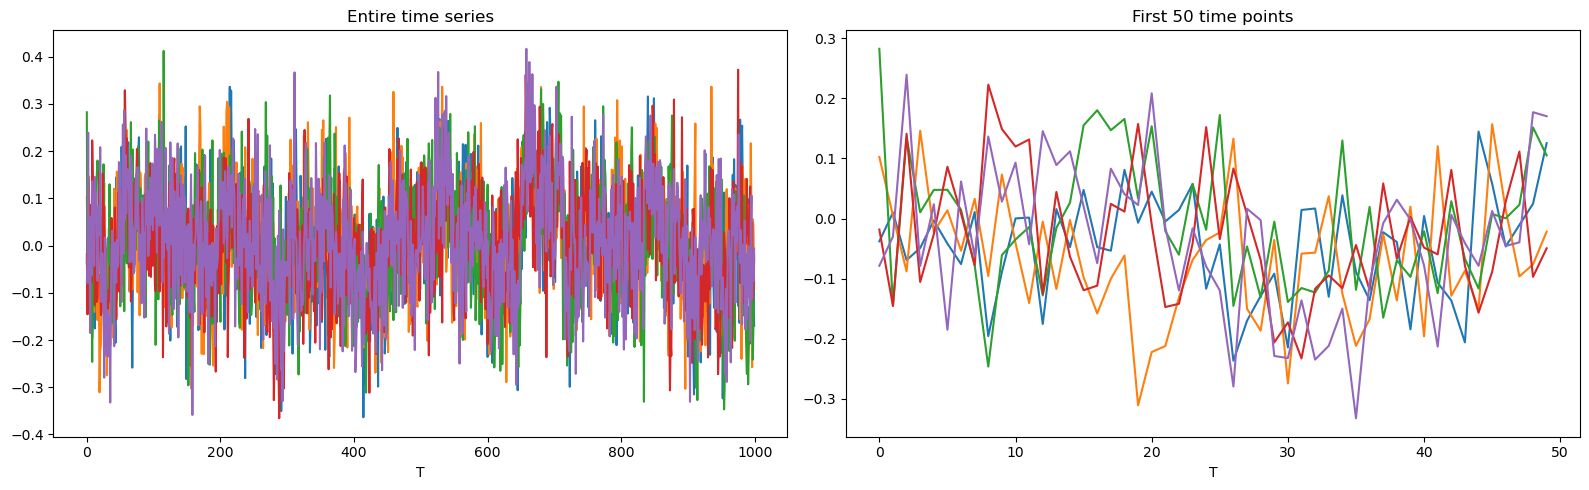

In [4]:
# Plot data
fig, axarr = plt.subplots(1, 2, figsize=(16, 5))
axarr[0].plot(X_np)
axarr[0].set_xlabel('T')
axarr[0].set_title('Entire time series')
axarr[1].plot(X_np[:50])
axarr[1].set_xlabel('T')
axarr[1].set_title('First 50 time points')
plt.tight_layout()
plt.show()

Plot the granger causality among time series

[[1 0 0 1 1]
 [1 1 0 1 0]
 [1 0 1 0 1]
 [1 1 0 1 0]
 [0 1 1 0 1]]


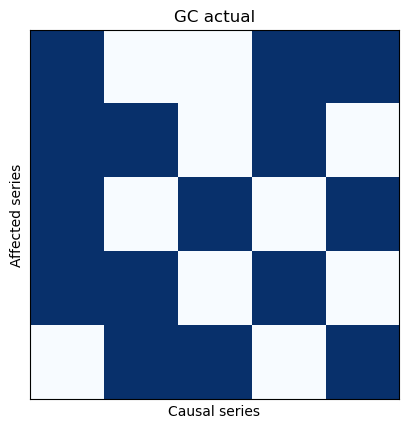

In [5]:
print(GC)

plt.imshow(GC, cmap='Blues')
plt.title('GC actual')
plt.ylabel('Affected series')
plt.xlabel('Causal series')
plt.xticks([])
plt.yticks([])
# plt.colorbar()
plt.show()

## 4. Prepare the Data

- In this section, we choose TS1 as the target time series.

- The lags of the rest 4 series and TS1 itself will be used to predict the current value of TS1.

- For TS1, it is affected by TS0, TS1, TS3.

In [6]:
def pd_data(X):
    '''
    Use dataframe to show the data structure
    Y: target series
    ts{}_lag{}: value of time series {} with lag {}
    '''
    Y = X[:, :, target_series]
    df = pd.DataFrame({'Y': Y[0,:].detach().numpy()})[lag:]
    for i in range(num_series):
        for j in range(lag):
            df['ts{}_lag{}'.format(i, lag-j)] = X[0, :, i].detach().numpy()[j:-lag+j]
    return df

In [7]:
target_series = 1  # the series we want to predict

def rearrange_data(X):
    '''
    Rearrange the time series, to form a data with lags

    Input:
        X: tensor with shape (1, num_series, T)
    Output:
        array: tensor with shape (num_series * lag, T-lag)
    '''
    li = []
    for i in range(num_series):
        for j in range(lag):
            li.append(X[0, :, i].detach().numpy()[j:-lag+j])

    # transfer li to tensor
    array = torch.tensor(li, dtype=torch.float32)

    return array

In [8]:
array = rearrange_data(X).T
print(array.shape)

Y = X[:, :, target_series][0, :T-lag].reshape(1, T-lag).T
print(Y.shape)

# Show the data structure using dataframe
# pd_data(X)

# put the data into DataLoader
trainloader = DataLoader(TensorDataset(array, Y), batch_size=32, shuffle=True)

torch.Size([997, 15])
torch.Size([997, 1])


/var/folders/yl/m5cgc23j1gbfcvxxglrgsk0w0000gn/T/ipykernel_69603/3327945439.py:18: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_9d63z49rj_/croot/pytorch_1681837279022/work/torch/csrc/utils/tensor_new.cpp:233.)
  array = torch.tensor(li, dtype=torch.float32)


## 5. Predict using KAN

In [30]:
layers = [4, 8, 16]
kan_loss_all = []
kan_output_all = []

for layer in layers:
    model = KAN([dim_input, layer, dim_output])
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    kan_loss = []
    print("-" * 10)
    print("Hidden layer number: ", layer)

    for epoch in range(epochs):
        # Train
        model.train()
        for i, data in enumerate(trainloader):
            inputs, labels = data
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            kan_loss.append(loss.item())
            loss.backward()
            optimizer.step()

        if (epoch+1) % 5 == 0:
            print('Epoch: {}, loss: {}'.format(epoch + 1, loss.item()))
    
    kan_output_all.append(model(array).detach().numpy())
    kan_loss_all.append(kan_loss)

----------
Hidden layer number:  4
Epoch: 5, loss: 0.011255891062319279
Epoch: 10, loss: 0.0005792967276647687
Epoch: 15, loss: 3.523526174831204e-05
Epoch: 20, loss: 1.7639908037381247e-05
----------
Hidden layer number:  8
Epoch: 5, loss: 0.0076951077207922935
Epoch: 10, loss: 4.103492392459884e-05
Epoch: 15, loss: 8.506362974003423e-06
Epoch: 20, loss: 1.3956212569610216e-05
----------
Hidden layer number:  16
Epoch: 5, loss: 0.004725567065179348
Epoch: 10, loss: 1.2127418813179247e-05
Epoch: 15, loss: 6.901472715981072e-06
Epoch: 20, loss: 2.9228953280835412e-05


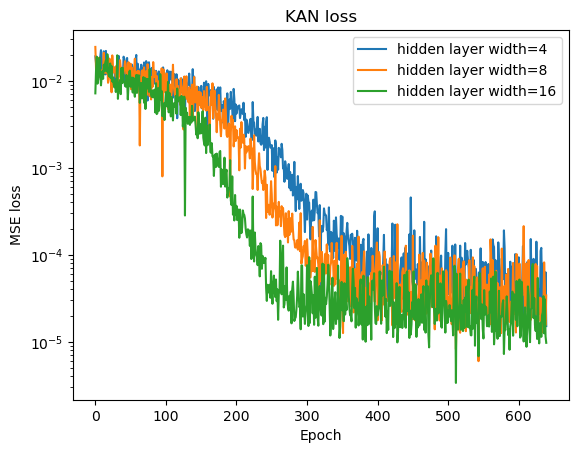

In [29]:
for i, kan_loss in enumerate(kan_loss_all):
    plt.plot(kan_loss, label='hidden layer width={}'.format(layers[i]))
    # log scale 
    plt.yscale('log')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('MSE loss')
    plt.title('KAN loss')
plt.show()

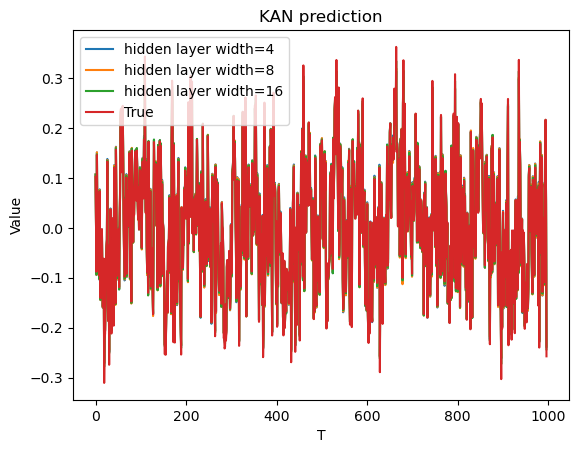

In [31]:
for i, kan_output in enumerate(kan_output_all):
    plt.plot(kan_output, label='hidden layer width={}'.format(layers[i]))
plt.plot(Y, label='True')
plt.legend()
plt.xlabel('T')
plt.ylabel('Value')
plt.title('KAN prediction')
plt.show()